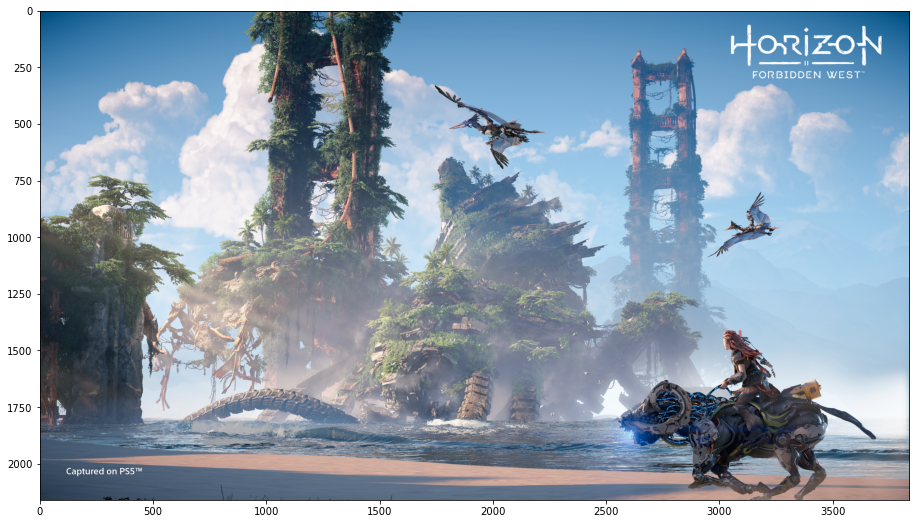

In [77]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import time
from copy import copy as cp

picture = cv.cvtColor(cv.imread('12.png'),cv.COLOR_BGR2RGB)
plt.figure(figsize = (16, 9))
plt.imshow(picture)
plt.show()

Представленная картинка (просто взята из папки с обоями на личном пк) имеет разрешение 3840x2160, то есть порядка 8.2944 мегапикселя. Для ускорения процесса рассмотрим только кусочек 1000x1000. 

## OpenCV

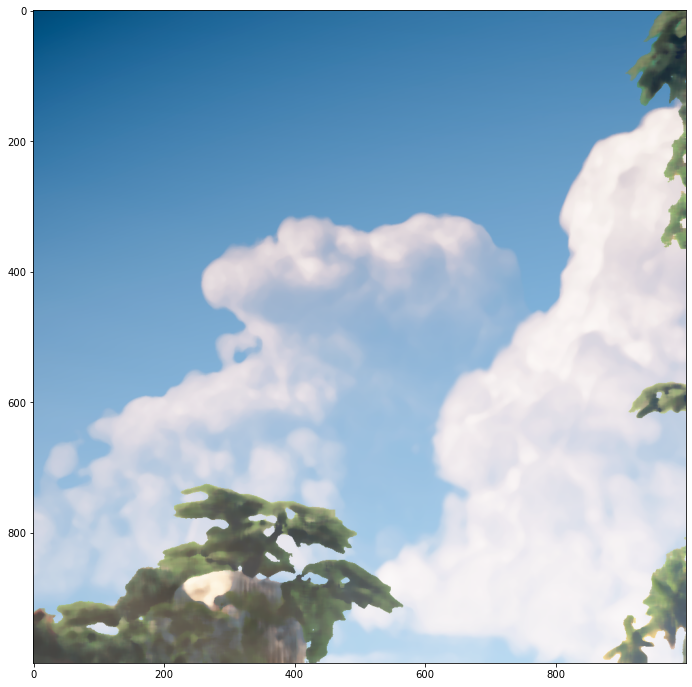

In [70]:
ethalon_picture = cv.medianBlur(picture[:1000, :1000], 11)
plt.figure(figsize=(12, 12))
plt.imshow(ethalon_picture)
plt.show()

## Сортировка
Нахождение медианы методом простой сортировки обходится нам в $O(R^2\log R)$ времени и затраты по памяти в размере $O(R^2)$ на хранение окошка

In [46]:
def get_median_np_median(window):
    return np.median(window, axis = (0,1))
def median_filter_sort(picture, R):
    pad_format = [[R, R], [R, R], [0, 0]] if len(picture.shape) == 3 else [[R, R], [R, R]]
    padded_picture = np.pad(picture, pad_format, "median")
    new_picture = np.zeros_like(picture)
    for i in range(picture.shape[0]):
        for j in range(picture.shape[1]):
            window = padded_picture[i:i + 2 * R + 1, j:j + 2 * R + 1]
            new_picture[i, j] = get_median_np_median(window)
    return new_picture

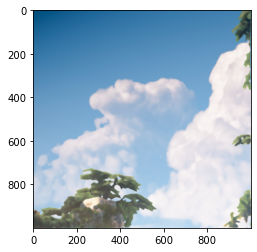

In [47]:
filtered_sort = median_filter_sort(picture[:1000, :1000], 5)
plt.figure()
plt.imshow(filtered_sort)
plt.show()

## Huang et al.
Для расчета медианы данным методом мы в рамках одной строки тратим $O(R^2)$ на создание начальной гистограммы и затем обновляем её за $O(R)$, что позволяет нам при достаточно больших размерах изображения и неочень больших размерах собственно R получить амортизированное $O(R)$
По памяти мы получаем $O(N)$, где в нашем случае $N \le 256$, так что по сути $O(1)$

In [88]:
def update_histogram(old_row, new_row, histogram):
    hist = cp(histogram)
    hist += np.histogram(new_row, bins=256, range = (0, 255))[0]
    hist -= np.histogram(old_row, bins=256, range = (0, 255))[0]
    return hist


def median_filter_huang(picture, R):
    pad_format = [[R, R], [R, R], [0, 0]] if len(picture.shape) == 3 else [[R, R], [R, R]]
    padded_picture = np.pad(picture, pad_format, "median")
    new_picture = np.zeros_like(picture)
    if len(picture.shape) == 2:
        padded_picture = padded_picture.reshape((padded_picture.shape[0], padded_picture.shape[1], 1))
        new_picture = new_picture.reshape((picture.shape[0], picture.shape[1], 1))
    half = 2 * R *(R + 1)
    for c in range(padded_picture.shape[2]):
        for i in tqdm(range(picture.shape[0])):
            histogram = np.histogram(padded_picture[i:i + 2 * R + 1, :2 * R + 1, c], bins = 256, range = (0, 255))[0]
            for j in range(picture.shape[1]):
                median = 0
                count = 0
                while median < 255:
                    count += histogram[median]
                    if count > half:
                        break
                    median += 1
                new_picture[i, j, c] = median
                if j != picture.shape[1] - 1:
                    histogram = update_histogram(padded_picture[i:i + 2 * R + 1, j, c], 
                                                 padded_picture[i:i + 2 * R + 1, j + 2 * R + 1, c], 
                                                 histogram)
    return new_picture

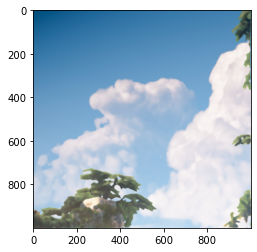

Wall time: 13min 2s


In [89]:
%%time
filtered_huang = median_filter_huang(picture[:1000, :1000], 5)
plt.figure()
plt.imshow(filtered_huang)
plt.show()

## Константное время
Собственно из названия понятно, что данная реализация должна занимать по времени хотя бы амортизированное $O(1)$. В целом оно так и есть, вроде как, обновление происходит быстро, но по памяти выходит неэффективно, поскольку нужно хранить массив из $N * width$ элементов (по гистограмме на каждый столбец), то есть памяти $O(N*W)$

In [62]:
def median_filter_fast(picture, R):
    pad_format = [[R, R], [R, R], [0, 0]] if len(picture.shape) == 3 else [[R, R], [R, R]]
    padded_picture = np.pad(picture, pad_format, "median")
    if len(picture.shape) == 2:
        padded_picture = padded_picture.reshape((padded_picture.shape[0], padded_picture.shape[1], 1))
    new_picture = np.zeros_like(picture).reshape((picture.shape[0], picture.shape[1], 1))
    half = 2 * R *(R + 1)
    
    for c in range(padded_picture.shape[2]):
        histograms = np.zeros((picture.shape[1], 256))
        histograms[0] = np.histogram(padded_picture[:2 * R + 1, :2 * R + 1, c], bins = 256, range = (0, 255))[0]
        for i in range(picture.shape[0]):
            for j in range(picture.shape[1]):
                median = 0
                count = 0
                while median < 255:
                    count += histograms[j][median]
                    if count > half:
                        break
                    median += 1
                new_picture[i, j, c] = median
                if j != picture.shape[1] - 1 and i == 0:
                    histograms[j + 1] = update_histogram(padded_picture[i:i+2 * R + 1, j, c],
                                                         padded_picture[i:i+2 * R + 1, j + 2 * R + 1, c],
                                                         histograms[j])
                
                if i != picture.shape[0] - 1:
                    histograms[j] = update_histogram(padded_picture[i, j:j+2 * R + 1, c], 
                                                     padded_picture[i + 2 * R + 1, j:j+2 * R + 1, c], 
                                                     histograms[j])

    return new_picture

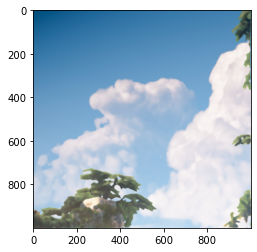

In [63]:
#filtered_fast = median_filter_fast(picture[:1000, :1000], 5)
plt.figure()
plt.imshow(filtered_fast)
plt.show()

Проверим, что все три алгоритма выдают идентичные результаты:

In [71]:
print(np.sum(ethalon_picture == filtered_sort))
print(np.sum(filtered_huang == filtered_sort))
print(np.sum(filtered_fast == filtered_sort))
print(picture[:1000, :1000].size)

2962229
3000000
3000000
3000000


Как можно заметить, все рукописные алгоритмы совпадают один в один и лишь слегка отлечаются от реализации из OpenCV. Связано это с тем, что в библиотечной реализации используется подход к паддингу, отсутствующий в numpy.pad (все доступные варианты не подошли)

## Замеры

Проведем замер на части изображения размером ровно 1/4 мегапикселя и с одним каналом. Так как вычисления по каждому из каналов проходят независимо, на качество измерения это никак не влияет.

In [65]:
%%time
times_opencv = []
times_sort = []
times_fast = []
times_huang = []
pic = picture[:500, :500, 0]

for R in tqdm(range(1, 100, 2)):
    start = time()
    cv.medianBlur(pic, R * 2 + 1)
    times_opencv.append((time() - start) * 1000)
    
    start = time()
    median_filter_sort(pic, R)
    times_sort.append((time() - start) * 1000)
    
    start = time()
    median_filter_huang(pic, R)
    times_huang.append((time() - start) * 1000)
    
    start = time()
    median_filter_fast(pic, R)
    times_fast.append((time() - start) * 1000)


Wall time: 1h 47min 45s


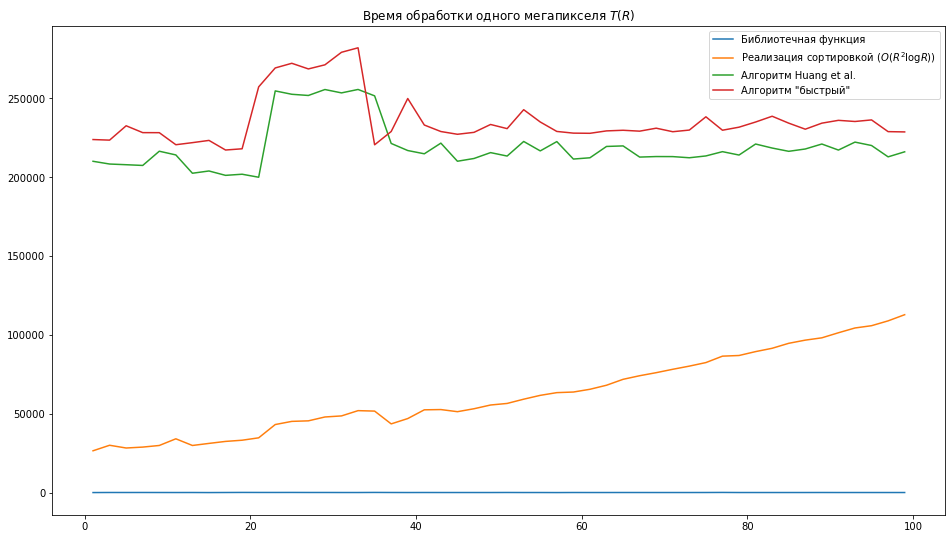

In [69]:
plt.figure(figsize = (16, 9))
grid = np.arange(1, 100, 2)
plt.plot(grid, np.array(times_opencv) * 4, label = "Библиотечная функция")
plt.plot(grid, np.array(times_sort) * 4, label = "Реализация сортировкой ($O(R^2\log R)$)")
plt.plot(grid, np.array(times_huang) * 4, label = "Алгоритм Huang et al.")
plt.plot(grid, np.array(times_fast) * 4,  label =  'Алгоритм "быстрый"')
plt.legend()
plt.title("Время обработки одного мегапикселя $T(R)$")
plt.show()

Как можно заметить, эффективность работы алгоритмов Huang'а и наиболее оптимизированной версии достаточно сомнительна, по крайней мере на рассмотренных R. Скорее всего с ростом R, алгоритм, основанный на простых сортировках, уступит место гистограммным реализациям.

Для красоты и наглядности посмотрим ещё, как релизованный алгоритм восстановит пингвинчика :)

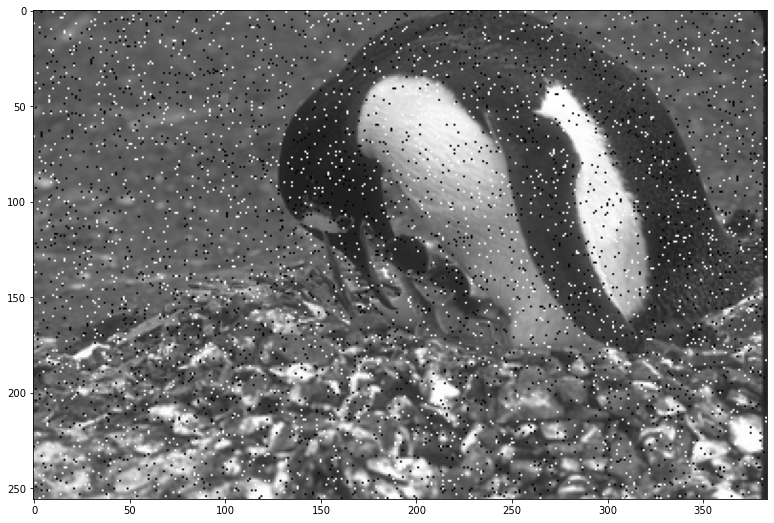

In [72]:
penguin = cv.imread('penguin.png')
plt.figure(figsize = (16, 9))
plt.imshow(penguin)
plt.show()

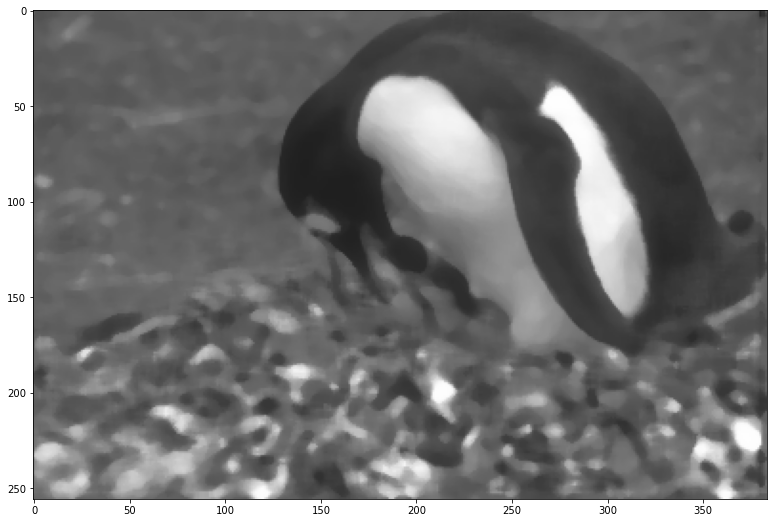

In [75]:
plt.figure(figsize = (16, 9))
plt.imshow(median_filter_sort(penguin, 3))
plt.show()